In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

INFO:tensorflow:Using local port 15871
INFO:tensorflow:Using local port 15060
INFO:tensorflow:Using local port 18879
INFO:tensorflow:Using local port 24993
INFO:tensorflow:Using local port 18627
INFO:tensorflow:Using local port 23661
INFO:tensorflow:Using local port 16594
INFO:tensorflow:Using local port 19488
INFO:tensorflow:Using local port 15410
INFO:tensorflow:Using local port 24693
python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [64]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

In [4]:
dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [5]:
dataset = dataframe.values

In [6]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

In [7]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

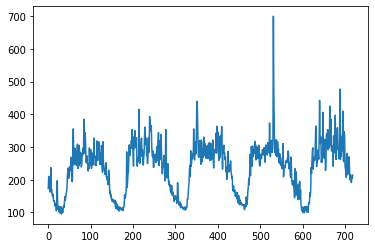

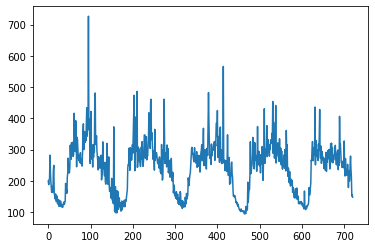

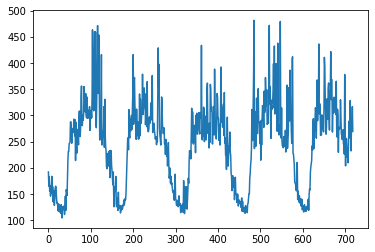

In [8]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


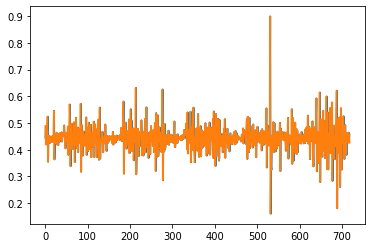

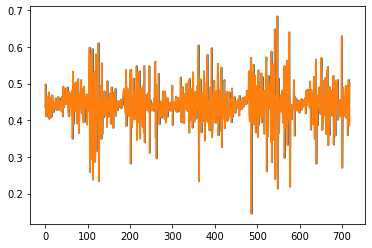

In [9]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [10]:
hunits = 2

In [11]:
file_object =  open('results.csv', 'w')
file_object.write("Hunit; Seuil; Count; Total; Proportion \n")

40

In [12]:
for hunits in range(1,15):

    lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        expected = raw_values[len(train) + i + 1]

        predictions.append(yhat)

    for k in range(1,200):
        count = 1
        for i in range(len(test_scaled)):
            if ((np.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>(0.005*k)) :
                count+=1
        file_object.write('%d; %.3f; %d; %d; %.2f \n' % (hunits, 0.5*k, ((len(test_scaled)-count)/len(test_scaled)*100), count, len(test_scaled)))

(1439, 1, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1)                    12        
_________________________________________________________________
output (Dense)               (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
(1439, 1, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 2)                    32        
_________________________________________________________________
output (Dense)               (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
(1439, 1, 1)
Mod

In [13]:
file_object.close()

In [1]:
from pandas import read_csv
resultats = read_csv('results_dp.txt', usecols=[0,1,2], engine='python', sep =";")

In [2]:
set_resultat = resultats.values

In [5]:
set_resultat = set_resultat.astype('float32')
where_are_NaNs = np.isnan(set_resultat)
set_resultat[where_are_NaNs] = 0

In [6]:
set_resultat

array([[ 1.  ,  0.5 ,  3.89],
       [ 1.  ,  1.  ,  7.65],
       [ 1.  ,  1.5 , 10.57],
       ...,
       [ 9.  , 72.  , 99.72],
       [ 9.  , 72.5 , 99.72],
       [ 9.  , 73.  , 99.72]], dtype=float32)

In [7]:
newdataset1 = []
newdataset2 = []
newdataset3 = []

for i in range(len(set_resultat)):
    a = set_resultat[i,0]
    b = set_resultat[i,1]
    c = set_resultat[i,2]
    if b<70 :
        newdataset1.append(a)
        newdataset2.append(b)
        newdataset3.append(c)

In [8]:
newdataset1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0

In [9]:
newdataset2

[0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5,
 28.0,
 28.5,
 29.0,
 29.5,
 30.0,
 30.5,
 31.0,
 31.5,
 32.0,
 32.5,
 33.0,
 33.5,
 34.0,
 34.5,
 35.0,
 35.5,
 36.0,
 36.5,
 37.0,
 37.5,
 38.0,
 38.5,
 39.0,
 39.5,
 40.0,
 40.5,
 41.0,
 41.5,
 42.0,
 42.5,
 43.0,
 43.5,
 44.0,
 44.5,
 45.0,
 45.5,
 46.0,
 46.5,
 47.0,
 47.5,
 48.0,
 48.5,
 49.0,
 49.5,
 50.0,
 50.5,
 51.0,
 51.5,
 52.0,
 52.5,
 53.0,
 53.5,
 54.0,
 54.5,
 55.0,
 55.5,
 56.0,
 56.5,
 57.0,
 57.5,
 58.0,
 58.5,
 59.0,
 59.5,
 60.0,
 60.5,
 61.0,
 61.5,
 62.0,
 62.5,
 63.0,
 63.5,
 64.0,
 64.5,
 65.0,
 65.5,
 66.0,
 66.5,
 67.0,
 67.5,
 68.0,
 68.5,
 69.0,
 69.5,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0

In [10]:
newdataset3

[3.89,
 7.65,
 10.57,
 13.49,
 17.39,
 20.17,
 22.53,
 25.59,
 28.65,
 31.02,
 32.96,
 35.74,
 38.11,
 40.47,
 43.95,
 46.59,
 48.68,
 50.35,
 51.88,
 53.55,
 54.94,
 57.3,
 58.83,
 61.34,
 63.0,
 64.67,
 66.48,
 68.15,
 68.98,
 70.79,
 71.77,
 72.74,
 74.83,
 76.5,
 77.89,
 79.0,
 79.97,
 80.11,
 81.22,
 81.64,
 82.06,
 82.75,
 83.31,
 84.42,
 85.54,
 86.51,
 87.2,
 87.9,
 88.87,
 89.29,
 90.54,
 90.82,
 90.82,
 91.66,
 91.93,
 92.63,
 92.77,
 92.77,
 93.6,
 93.74,
 94.16,
 94.71,
 94.85,
 94.85,
 95.13,
 95.69,
 95.69,
 95.83,
 95.83,
 96.11,
 96.11,
 96.24,
 96.38,
 96.52,
 96.8,
 96.8,
 96.94,
 97.08,
 97.08,
 97.22,
 97.36,
 97.64,
 97.77,
 97.77,
 97.77,
 97.91,
 97.91,
 98.19,
 98.19,
 98.19,
 98.19,
 98.19,
 98.33,
 98.47,
 98.47,
 98.47,
 98.47,
 98.61,
 98.61,
 98.61,
 98.75,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 99.03,
 99.03,
 99.03,
 99.03,
 99.03,
 99.17,
 99.17,
 99.17,
 99.3,
 99.3,
 99.3,
 99.3,

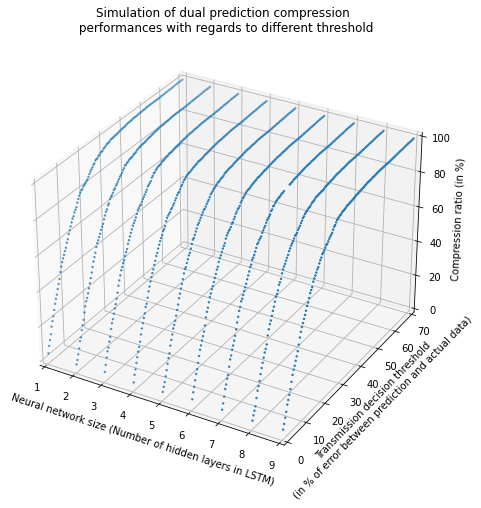

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.plot(newdataset1, newdataset2, newdataset3) 
ax.set_title('Simulation of dual prediction compression \n performances with regards to different threshold') 
  
# label x-axis and y-axis 
ax.set_xlabel('Neural network size (Number of hidden layers in LSTM)') 
ax.set_ylabel('Transmission decision threshold \n(in % of error between prediction and actual data)') 
ax.set_zlabel('Compression ratio (in %)') 

# set x, y-axis limits  
ax.set_xlim(1, 9) 
ax.set_ylim(0, 70) 
ax.set_zlim(0, 100) 


ax.scatter(newdataset1, newdataset2, newdataset3, s=2)


#plt.plot(newdataset2[1791:1990], newdataset3[1791:1990], c='green')

#plt.plot(newdataset2, newdataset3) 
plt.show()




In [92]:
col = np.arange(2786)
for i in range(0,2786) :
    col[i] = np.log((col[i]%199) +1)
col

array([0, 0, 1, ..., 5, 5, 5])

In [9]:
set_resultat[0,0]

1.0

In [13]:
newdataset1 = []
newdataset2 = []
newdataset3 = []

for i in range(len(set_resultat)):
    a = set_resultat[i,0]
    b = set_resultat[i,1]
    c = set_resultat[i,2]
    newdataset1.append(a)
    newdataset2.append(b)
    newdataset3.append(c)

In [14]:
newdataset1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [15]:
newdataset2

[0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5,
 28.0,
 28.5,
 29.0,
 29.5,
 30.0,
 30.5,
 31.0,
 31.5,
 32.0,
 32.5,
 33.0,
 33.5,
 34.0,
 34.5,
 35.0,
 35.5,
 36.0,
 36.5,
 37.0,
 37.5,
 38.0,
 38.5,
 39.0,
 39.5,
 40.0,
 40.5,
 41.0,
 41.5,
 42.0,
 42.5,
 43.0,
 43.5,
 44.0,
 44.5,
 45.0,
 45.5,
 46.0,
 46.5,
 47.0,
 47.5,
 48.0,
 48.5,
 49.0,
 49.5,
 50.0,
 50.5,
 51.0,
 51.5,
 52.0,
 52.5,
 53.0,
 53.5,
 54.0,
 54.5,
 55.0,
 55.5,
 56.0,
 56.5,
 57.0,
 57.5,
 58.0,
 58.5,
 59.0,
 59.5,
 60.0,
 60.5,
 61.0,
 61.5,
 62.0,
 62.5,
 63.0,
 63.5,
 64.0,
 64.5,
 65.0,
 65.5,
 66.0,
 66.5,
 67.0,
 67.5,
 68.0,
 68.5,
 69.0,
 69.5,
 70.0,
 70.5,
 71.0,
 71.5,
 72.0,
 72.5,
 73.

In [16]:
newdataset3

[3.89,
 7.65,
 10.57,
 13.49,
 17.39,
 20.17,
 22.53,
 25.59,
 28.65,
 31.02,
 32.96,
 35.74,
 38.11,
 40.47,
 43.95,
 46.59,
 48.68,
 50.35,
 51.88,
 53.55,
 54.94,
 57.3,
 58.83,
 61.34,
 63.0,
 64.67,
 66.48,
 68.15,
 68.98,
 70.79,
 71.77,
 72.74,
 74.83,
 76.5,
 77.89,
 79.0,
 79.97,
 80.11,
 81.22,
 81.64,
 82.06,
 82.75,
 83.31,
 84.42,
 85.54,
 86.51,
 87.2,
 87.9,
 88.87,
 89.29,
 90.54,
 90.82,
 90.82,
 91.66,
 91.93,
 92.63,
 92.77,
 92.77,
 93.6,
 93.74,
 94.16,
 94.71,
 94.85,
 94.85,
 95.13,
 95.69,
 95.69,
 95.83,
 95.83,
 96.11,
 96.11,
 96.24,
 96.38,
 96.52,
 96.8,
 96.8,
 96.94,
 97.08,
 97.08,
 97.22,
 97.36,
 97.64,
 97.77,
 97.77,
 97.77,
 97.91,
 97.91,
 98.19,
 98.19,
 98.19,
 98.19,
 98.19,
 98.33,
 98.47,
 98.47,
 98.47,
 98.47,
 98.61,
 98.61,
 98.61,
 98.75,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 98.89,
 99.03,
 99.03,
 99.03,
 99.03,
 99.03,
 99.17,
 99.17,
 99.17,
 99.3,
 99.3,
 99.3,
 99.3,

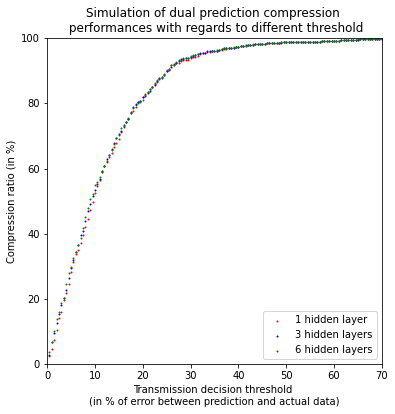

In [17]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d

fig, ax = plt.subplots(figsize = (6,6))
#ax = fig.add_subplot(111, projection='3d')

ax.set_title('Simulation of dual prediction compression \n performances with regards to different threshold') 
  
# label x-axis and y-axis 
ax.set_xlabel('Transmission decision threshold \n(in % of error between prediction and actual data)') 
ax.set_ylabel('Compression ratio (in %)') 

# set x, y-axis limits  
ax.set_xlim(0, 70) 
ax.set_ylim(0, 100) 
for i,col in [(1,'red'),(3, 'blue'),(6, 'green')]:
    if i == 1 : 
        label = "1 hidden layer"
    else:
        label = (str) (i) + " hidden layers"    
    plt.scatter(newdataset2[(i*199): ((i+1)*198)-1], newdataset3[(i*199): ((i+1)*198)-1], s=1, c=col, label = label)
    ax.legend(loc='lower right')

#plt.plot(newdataset2[1791:1990], newdataset3[1791:1990], c='green')

#plt.plot(newdataset2, newdataset3) 
plt.show()